N U Praneeth Reddy - 21BIA1500

### import libraries

In [8]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

### import the data

In [9]:
data = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
data.head(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [10]:
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0

In [11]:
def prepare_dataset(df):
    df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
    df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))

    left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
    right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values

    left_normal = df.loc[(df.C ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
    right_normal = df.loc[(df.C ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values

    cataract = np.concatenate((left_cataract,right_cataract),axis=0)
    normal = np.concatenate((left_normal,right_normal),axis=0)
    
    return cataract,normal;

In [12]:
cataract,normal = prepare_dataset(data)


In [13]:
print('No of Cataract Images is :',len(cataract))
print('No of Normal Images is :',len(normal))


No of Cataract Images is : 594
No of Normal Images is : 500


In [14]:
import cv2
import numpy as np
from tqdm import tqdm

dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images"
image_size = 224
labels = []
dataset = []

def dataset_generator(imagecategory, label):
    for img in tqdm(imagecategory):
        imgpath = os.path.join(dataset_dir, img)

        try:
            image = cv2.imread(imgpath, cv2.IMREAD_COLOR)
            image = cv2.resize(image, (image_size, image_size))
        except:
            continue
        dataset.append(np.array(image))
        labels.append(np.array(label))
    return dataset, labels



In [15]:
dataset, labels = dataset_generator(normal, 0)


100%|██████████| 500/500 [00:24<00:00, 20.06it/s]


In [16]:

dataset, labels = dataset_generator(cataract, 1)


100%|██████████| 594/594 [00:29<00:00, 20.14it/s]


In [17]:
print('Total no of images is :',len(dataset))

Total no of images is : 1094


In [18]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.applications import VGG19
from keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization,Dropout
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint



In [19]:
X = np.array(dataset)
y = np.array(labels)


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

In [21]:
print("X_train:",len(X_train))
print("X_test:",len(X_test))
print("y_train:",len(y_train))
print("y_test:",len(y_test))

X_train: 875
X_test: 219
y_train: 875
y_test: 219


In [22]:
# Perform data augmentation using ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


# Apply data augmentation on the training data and create augmented images
augmented_data = datagen.flow(X_train, y_train, batch_size=32)

## RESNET50

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2

from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2

In [19]:
# Load the ResNet50 model with pre-trained weights
base_model50 = ResNet50(weights='imagenet', include_top=False,pooling='avg',input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model50.layers:
    layer.trainable = False

model50 = Sequential()
model50.add(base_model50)
model50.add(Flatten())
model50.add(BatchNormalization())
model50.add(Dense(512, activation='relu'))  
model50.add(BatchNormalization())
model50.add(Dropout(0.5))
model50.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001)))  # Adding L2 regularization

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
model50.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

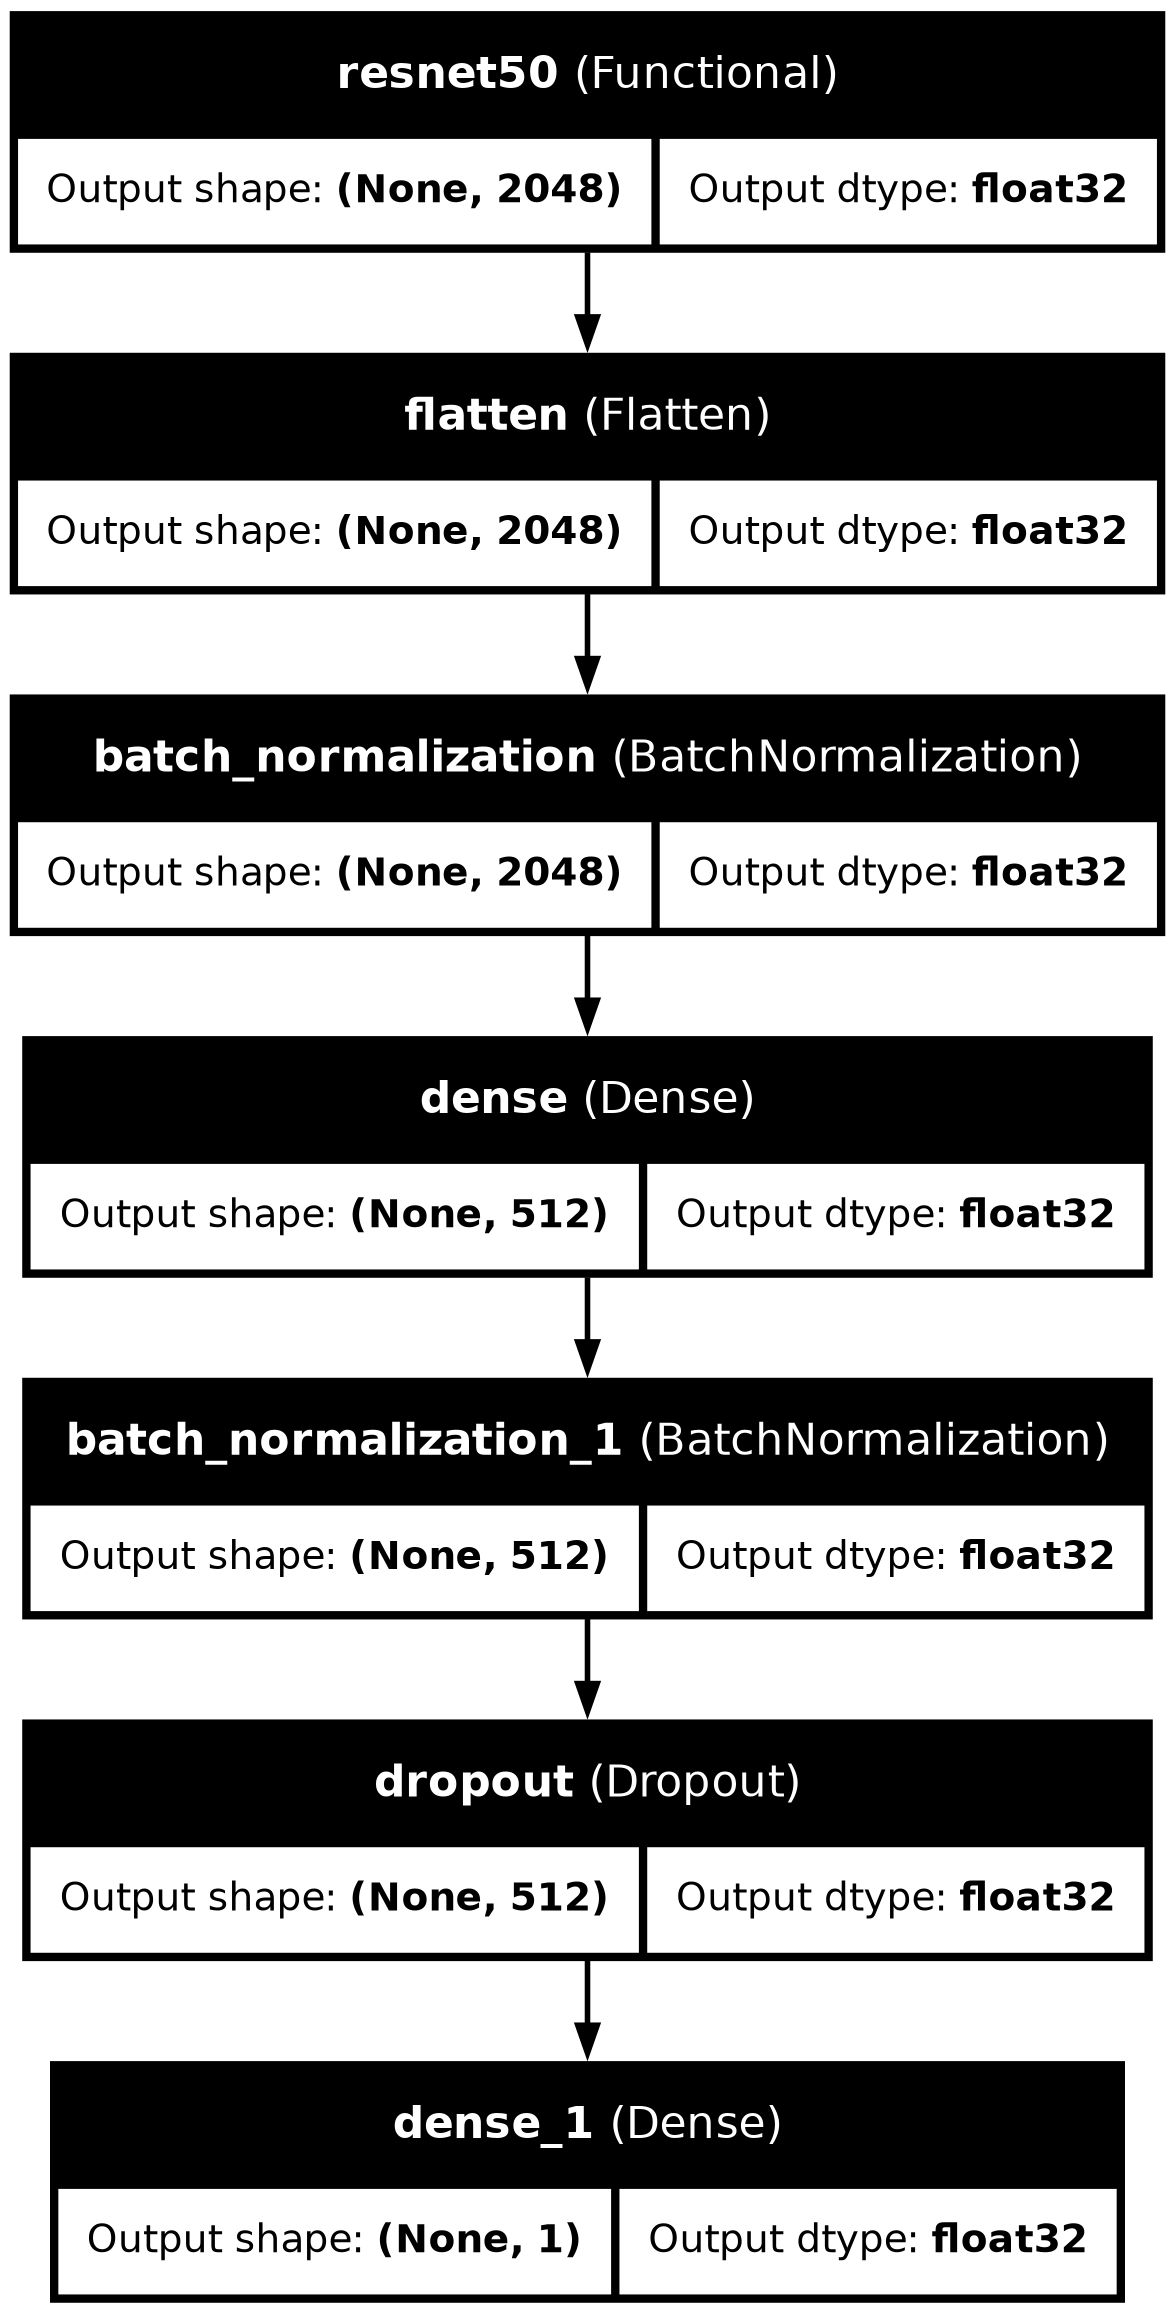

In [25]:


keras.utils.plot_model(model50, show_dtype=True, show_layer_names=True, show_shapes=True, to_file='model50.png')  


In [22]:
# ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(
    filepath = "/kaggle/working/RESNET50best_model1.keras",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [23]:
model50.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [24]:
history50 = model50.fit(augmented_data,epochs=40,validation_data=(X_test, y_test),callbacks=[model_checkpoint])

Epoch 1/40
 2/28 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.7734 - loss: 0.5413 

I0000 00:00:1713800948.912130      85 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713800948.966306      85 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.8710 - loss: 0.4035

W0000 00:00:1713800965.122897      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.92694, saving model to /kaggle/working/RESNET50best_model1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 40s 789ms/step - accuracy: 0.8719 - loss: 0.4021 - val_accuracy: 0.9269 - val_loss: 0.1601
Epoch 2/40
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9204 - loss: 0.2437
Epoch 2: val_accuracy improved from 0.92694 to 0.94064, saving model to /kaggle/working/RESNET50best_model1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.9202 - loss: 0.2426 - val_accuracy: 0.9406 - val_loss: 0.1339
Epoch 3/40
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9368 - loss: 0.1780
Epoch 3: val_accuracy improved from 0.94064 to 0.95890, saving model to /kaggle/working/RESNET50best_model1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 259ms/step - accuracy: 0.9371 - loss: 0.1781 - val_accuracy: 0.9589 - val_loss: 0.0931
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9412 - loss: 0.2018
Epoch 4: val_accuracy did not improve from 0.95890

In [43]:
history50 = model50.fit(augmented_data,epochs=30,validation_data=(X_test, y_test),callbacks=[model_checkpoint])

Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step - accuracy: 0.9692 - loss: 0.1209
Epoch 1: val_accuracy did not improve from 0.98630
28/28 ━━━━━━━━━━━━━━━━━━━━ 35s 657ms/step - accuracy: 0.9691 - loss: 0.1209 - val_accuracy: 0.9817 - val_loss: 0.0652
Epoch 2/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9568 - loss: 0.1009
Epoch 2: val_accuracy did not improve from 0.98630
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 301ms/step - accuracy: 0.9572 - loss: 0.1002 - val_accuracy: 0.9817 - val_loss: 0.0761
Epoch 3/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9767 - loss: 0.0801
Epoch 3: val_accuracy did not improve from 0.98630
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - accuracy: 0.9765 - loss: 0.0801 - val_accuracy: 0.9772 - val_loss: 0.0751
Epoch 4/20
27/28 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9722 - loss: 0.0778
Epoch 4: val_accuracy did not improve from 0.98630
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 306ms/step - accuracy: 0.9718 - loss: 0.0786 - val_accuracy: 0.9817

In [44]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred50 = model50.predict(X_test)
y_pred_binary50 = (y_pred50 > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate classification report
print(classification_report(y_test, y_pred_binary50))


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 655ms/step
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       113
           1       0.97      1.00      0.99       106

    accuracy                           0.99       219
   macro avg       0.99      0.99      0.99       219
weighted avg       0.99      0.99      0.99       219



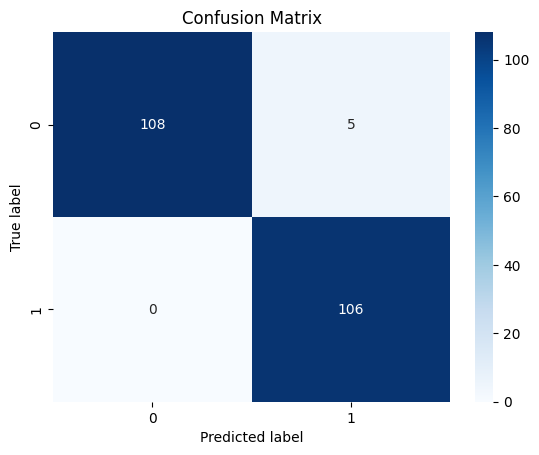

In [28]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix50 = confusion_matrix(y_test, y_pred_binary50)

# Plot heatmap
sns.heatmap(conf_matrix50, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


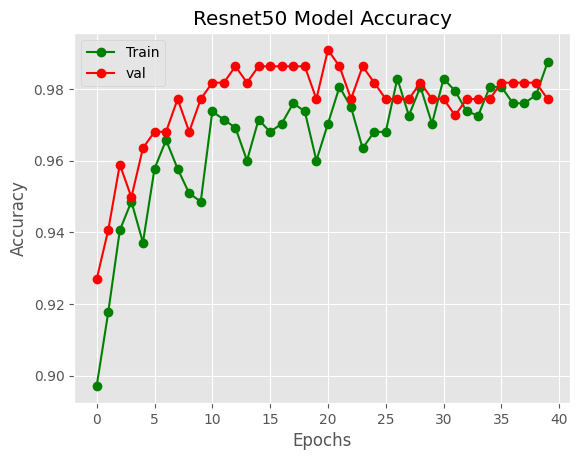

In [30]:
plt.style.use("ggplot")
plt.plot(history50.history["accuracy"],"go-")
plt.plot(history50.history["val_accuracy"],"ro-")
plt.title("Resnet50 Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")



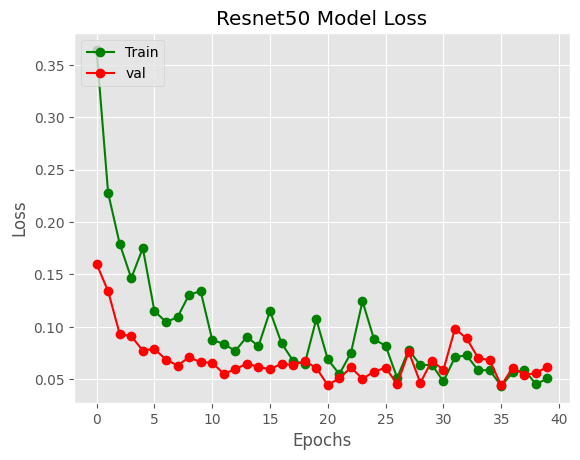

In [31]:
plt.plot(history50.history["loss"],"go-")
plt.plot(history50.history["val_loss"],"ro-")
plt.title("Resnet50 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

## RESNET101

In [5]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1, l2


In [20]:
# Load the ResNet101 model with pre-trained weights
base_model101 = ResNet101(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model101.layers:
    layer.trainable = False


171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [21]:
# ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpoint101 = ModelCheckpoint(
    filepath = "/kaggle/working/RESNET101bestmodel.keras",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [22]:
# Create a new model with L1 and L2 regularization
model101 = Sequential()
model101.add(base_model101)
model101.add(Flatten())
model101.add(BatchNormalization())
model101.add(Dense(512, activation='relu'))
model101.add(BatchNormalization())
model101.add(Dropout(0.5))
model101.add(Dense(1, activation='sigmoid'))



In [23]:
model101.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [24]:

# Train the model
history101 = model101.fit(augmented_data,epochs=40,validation_data=(X_test, y_test),callbacks=[model_checkpoint101])


Epoch 1/40
 1/28 ━━━━━━━━━━━━━━━━━━━━ 13:16 30s/step - accuracy: 0.5625 - loss: 1.0121

I0000 00:00:1713806983.143118      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 616ms/step - accuracy: 0.8506 - loss: 0.6952
Epoch 1: val_accuracy improved from -inf to 0.89954, saving model to /kaggle/working/RESNET101bestmodel.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 63s 1s/step - accuracy: 0.8520 - loss: 0.6888 - val_accuracy: 0.8995 - val_loss: 1.7168
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9192 - loss: 0.2553
Epoch 2: val_accuracy improved from 0.89954 to 0.93151, saving model to /kaggle/working/RESNET101bestmodel.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 16s 471ms/step - accuracy: 0.9193 - loss: 0.2563 - val_accuracy: 0.9315 - val_loss: 0.4344
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9398 - loss: 0.1803
Epoch 3: val_accuracy improved from 0.93151 to 0.94064, saving model to /kaggle/working/RESNET101bestmodel.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step - accuracy: 0.9394 - loss: 0.1819 - val_accuracy: 0.9406 - val_loss: 0.2154
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.

In [ ]:
from keras.models import load_model
model1011 = load_model('/kaggle/working/RESNET101bestmodel.keras')


In [25]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred101 = model1011.predict(X_test)
y_pred_binary101 = (y_pred101 > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate classification report
print(classification_report(y_test, y_pred_binary101))


7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       113
           1       0.99      0.97      0.98       106

    accuracy                           0.98       219
   macro avg       0.98      0.98      0.98       219
weighted avg       0.98      0.98      0.98       219



In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred_binary101)
print(f"Accuracy: {accuracy:.2f}")


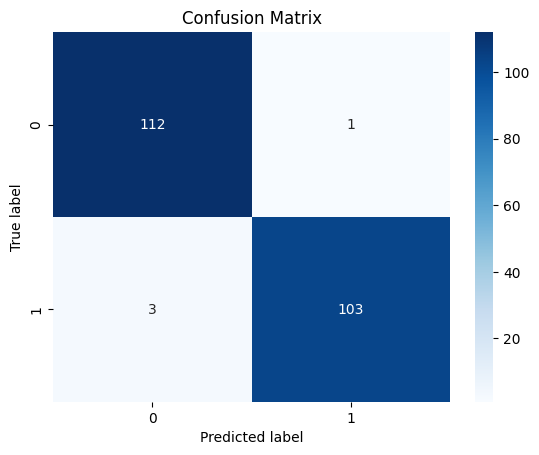

In [26]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix101 = confusion_matrix(y_test, y_pred_binary101)

# Plot heatmap
sns.heatmap(conf_matrix101, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


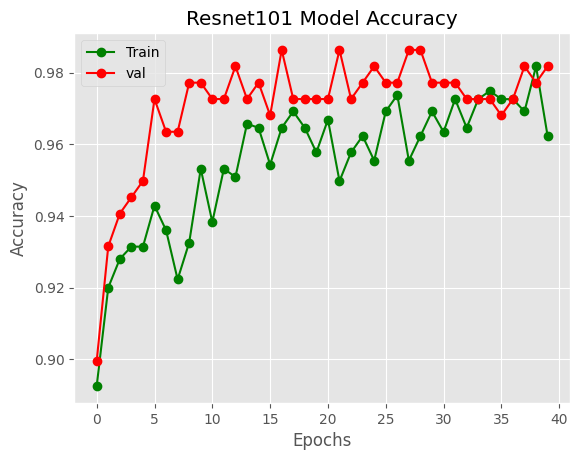

In [27]:
plt.style.use("ggplot")
plt.plot(history101.history["accuracy"],"go-")
plt.plot(history101.history["val_accuracy"],"ro-")
plt.title("Resnet101 Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")



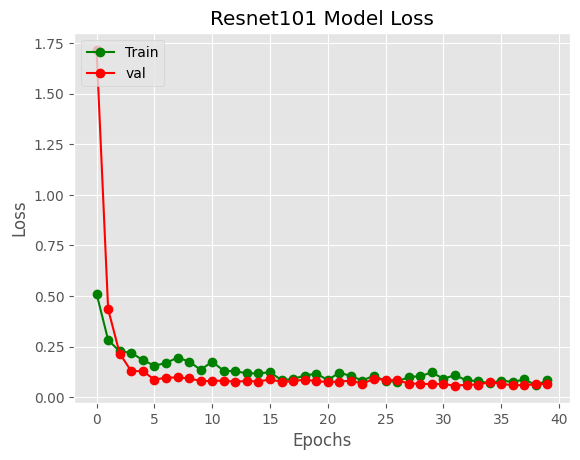

In [28]:
plt.plot(history101.history["loss"],"go-")
plt.plot(history101.history["val_loss"],"ro-")
plt.title("Resnet101 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()

## VGG19

In [33]:
# Step 4: Train VGG-19
base_model1 = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model1.layers:
    layer.trainable = False

x = base_model1.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x=BatchNormalization()(x)
predictions = Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=base_model1.input, outputs=predictions)



In [34]:
# ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint

model_checkpointvgg = ModelCheckpoint(
    filepath = "/kaggle/working/VGG19bestmodel1.keras",
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

In [35]:
from tensorflow.keras.callbacks import LearningRateScheduler
import math

def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.25
    epochs_drop = 5
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

learning_rate_scheduler = LearningRateScheduler(lr_schedule)


In [36]:
model1.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [37]:
history1 = model1.fit(augmented_data, epochs=40, validation_data=(X_test, y_test), callbacks=[model_checkpointvgg, learning_rate_scheduler])


Epoch 1/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step - accuracy: 0.7623 - loss: 0.4790
Epoch 1: val_accuracy improved from -inf to 0.53881, saving model to /kaggle/working/VGG19bestmodel1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 13s 312ms/step - accuracy: 0.7655 - loss: 0.4751 - val_accuracy: 0.5388 - val_loss: 2.8520 - learning_rate: 0.0010
Epoch 2/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9070 - loss: 0.3366
Epoch 2: val_accuracy improved from 0.53881 to 0.90868, saving model to /kaggle/working/VGG19bestmodel1.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step - accuracy: 0.9071 - loss: 0.3349 - val_accuracy: 0.9087 - val_loss: 0.2130 - learning_rate: 0.0010
Epoch 3/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9204 - loss: 0.2381
Epoch 3: val_accuracy did not improve from 0.90868
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 239ms/step - accuracy: 0.9201 - loss: 0.2380 - val_accuracy: 0.8037 - val_loss: 0.4692 - learning_rate: 0.0010
Epoch 4/40
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/ste

In [38]:
from keras.models import load_model
model19 = load_model('/kaggle/working/VGG19bestmodel1.keras')


In [38]:

history1 = model1.fit(augmented_data,epochs=20,validation_data=(X_test, y_test),callbacks=[model_checkpointvgg])


Epoch 1/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9341 - loss: 0.1773
Epoch 1: val_accuracy improved from -inf to 0.94064, saving model to /kaggle/working/VGG19bestmodel.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.9338 - loss: 0.1778 - val_accuracy: 0.9406 - val_loss: 0.1972
Epoch 2/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.9268 - loss: 0.1872
Epoch 2: val_accuracy did not improve from 0.94064
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - accuracy: 0.9269 - loss: 0.1867 - val_accuracy: 0.9406 - val_loss: 0.2019
Epoch 3/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.9307 - loss: 0.1807
Epoch 3: val_accuracy improved from 0.94064 to 0.95434, saving model to /kaggle/working/VGG19bestmodel.keras
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.9307 - loss: 0.1810 - val_accuracy: 0.9543 - val_loss: 0.1546
Epoch 4/20
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9286 - loss: 0.1997
Epoch 4: val_accuracy improved from 0.9

In [29]:
from sklearn.metrics import classification_report

# Make predictions on the test set
y_pred1 = model19.predict(X_test)
y_pred_binary1 = (y_pred1 > 0.5).astype(int)  # Convert probabilities to binary predictions

# Generate classification report
print(classification_report(y_test, y_pred_binary1))


7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       113
           1       0.96      0.99      0.98       106

    accuracy                           0.98       219
   macro avg       0.98      0.98      0.98       219
weighted avg       0.98      0.98      0.98       219



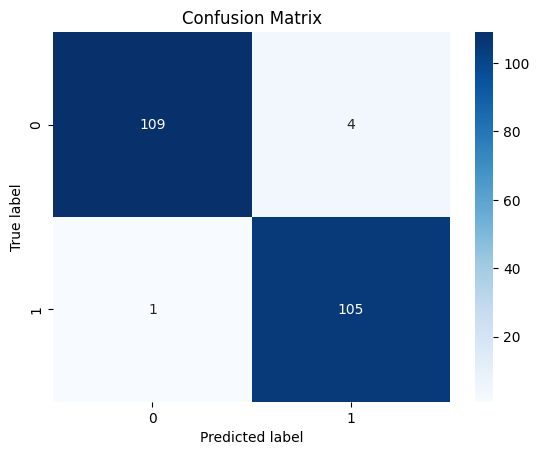

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
conf_matrix1 = confusion_matrix(y_test, y_pred_binary1)

# Plot heatmap
sns.heatmap(conf_matrix1, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()


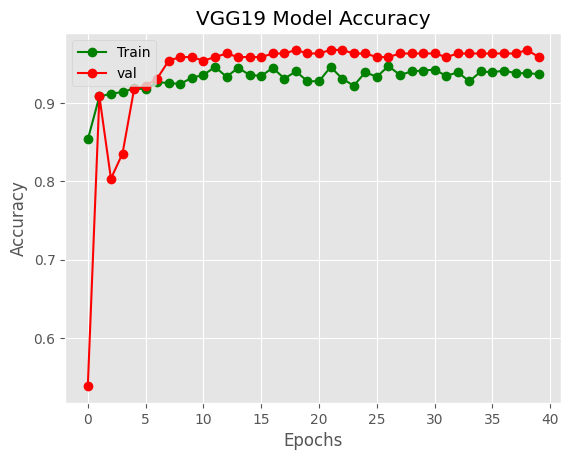

In [41]:

plt.style.use("ggplot")
plt.plot(history1.history["accuracy"],"go-")
plt.plot(history1.history["val_accuracy"],"ro-")
plt.title("VGG19 Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

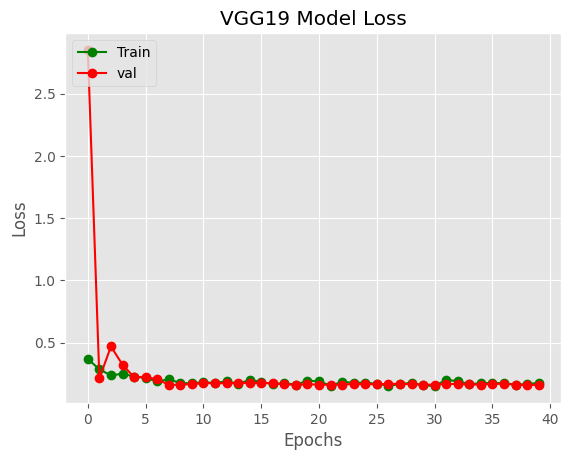

In [42]:
plt.plot(history1.history["loss"],"go-")
plt.plot(history1.history["val_loss"],"ro-")
plt.title("VGG19 Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()